In [32]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from keras.datasets import cifar10
from keras import backend as K # original
#from kears import keras.backend.tensorflow_backend as K
import tensorflow as tf
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

To read more about it, see [the original paper](https://arxiv.org/abs/1710.08864), or the authors' [official repo](https://github.com/Carina02/One-Pixel-Attack).

Let's get started.

![](images/pred2.png "All it takes is one pixel")

# One Pixel Attack Tutorial
## Part 1 - Cifar10

### Dan Kondratyuk
### September 15, 2019

We can access and display any image in the dataset by its index. For instance, here is a horse.

## Imports

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

Alternatively, you may [run this notebook in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7). Note: colab allows you to run this notebook on GPU, free of charge. Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

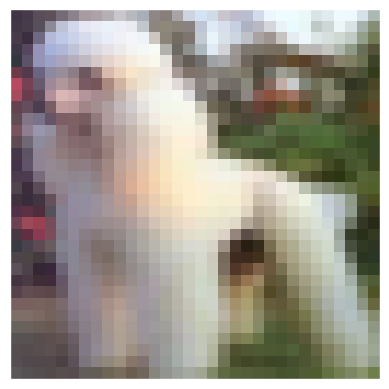

In [4]:
image_id = 520 # Image index in the test set
helper.plot_image(x_test[image_id])
#temp_img = Image.fromarray(x_test[image_id])
#temp_img.save("../Data_for_Paper/520.png", "png")

In [5]:
# this cell is added for test
print(type(x_test[0]))
print(type(y_test[0])) # blank image
temp_img = Image.fromarray(x_test[16])
print(x_test[16])
# temp_img2.show()
# print(temp_img.width)
# print(temp_img.height)
# temp_img.show()
# helper.plot_image(temp_img) # 얘는 걍 ndim array 넣어줘야 정상 작동하는듯??

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[[ 95  76  78]
  [ 92  77  78]
  [ 89  77  77]
  ...
  [ 30  28  38]
  [175 183 191]
  [225 234 240]]

 [[ 90  71  73]
  [ 86  72  72]
  [ 83  71  71]
  ...
  [  0   0  13]
  [ 60  63  79]
  [165 171 189]]

 [[ 88  69  71]
  [ 84  70  70]
  [ 82  70  70]
  ...
  [  5   0  12]
  [ 24  26  48]
  [127 139 165]]

 ...

 [[203 176 161]
  [213 175 156]
  [202 165 155]
  ...
  [182 183 189]
  [118 120 125]
  [ 37  32  46]]

 [[123  94  90]
  [210 170 157]
  [211 171 160]
  ...
  [116 116 120]
  [ 44  45  47]
  [ 11   3  15]]

 [[102  85  84]
  [208 183 175]
  [215 186 176]
  ...
  [ 37  33  43]
  [ 17  13  22]
  [ 22  11  28]]]


## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

In [6]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    # numpy tile(A, repeat_shape)
    # A라는 array가 repeat_shape 모양으로 쌓이도록
    # 추후에 다시 보자..
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        # pixels = 5-tuple of perturb information (x,y,r,g,b) by kyle
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel # *rgb = 뒤에 올 (r,g,b) 값을 가리킨다
            img[x_pos, y_pos] = rgb # perturb image by *rgb == (r,g,b) by kyle
    
    return imgs
    # Return value is array of perturbed images by xs
    # For example, if xs is [(16,16,255,255,0), (16,16,0,255,255)]
    # imgs is an array of perturbed image by xs[0], xs[1]. So it's size is 2 by kyle

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

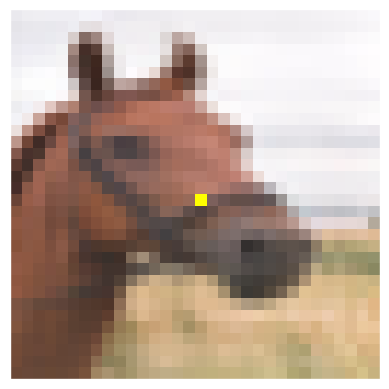

In [7]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. If you're [running in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7), you can enable a GPU instance by selecting `Runtime > Change runtime type > Hardware accelerator > GPU` (you will need to re-run all cells). The code below can be used to check (if using TensorFlow).

In [8]:
# Should output /device:GPU:0
#K.tensorflow_backend._get_available_gpus() #original
tf.compat.v1.disable_eager_execution()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

There are two models included in this repository, `lenet` and `resnet` which will be loaded from disk automatically.

Optionally, you may [download the larger, more accurate models](https://www.dropbox.com/sh/dvatkpjl0sn79kn/AAC9L4puJ_sdFUkDZfr5SFkLa?dl=0) (e.g., Capsule Network, DenseNet, etc.). Make sure to copy the models into the `networks/models/` directory. Then uncomment the lines below and run the cell to load the models of your choosing.

In [9]:
lenet = LeNet()
resnet = ResNet()

# originally, lenet and resnet

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
# resnet = ResNet()
densenet = DenseNet()
wide_resnet = WideResNet()
# capsnet = CapsNet()
# models = [lenet, resnet, wide_resnet]

models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

Metal device set to: Apple M1


2023-09-08 00:02:04.097082: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-08 00:02:04.106697: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/bias/Assign' id:115 op device:{requested: '', assigned: ''} def:{{{node dense_3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/bias, dense_3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Successfully loaded lenet
Instructions for updating:
Colocations handled automatically by placer.


2023-09-08 00:02:04.312504: W tensorflow/c/c_api.cc:300] Operation '{name:'decay/Assign' id:309 op device:{requested: '', assigned: ''} def:{{{node decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](decay, decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-08 00:02:05.359839: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_33/bias/Assign' id:2604 op device:{requested: '', assigned: ''} def:{{{node conv2d_33/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_33/bias, conv2d_33/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modi

Successfully loaded resnet


2023-09-08 00:02:06.577747: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_1_2/bias/Assign' id:5219 op device:{requested: '', assigned: ''} def:{{{node conv2d_1_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1_2/bias, conv2d_1_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-08 00:02:06.889965: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_7_1/kernel/v/Assign' id:5806 op device:{requested: '', assigned: ''} def:{{{node conv2d_7_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_7_1/kernel/v, conv2d_7_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Successfully loaded pure_cnn


2023-09-08 00:02:07.565448: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_8_1/beta/Assign' id:6533 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_8_1/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_8_1/beta, batch_normalization_8_1/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-08 00:02:07.987148: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_9_2/bias/momentum/Assign' id:7255 op device:{requested: '', assigned: ''} def:{{{node conv2d_9_2/bias/momentum/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_9_2/bias/momentum, conv2d_9_2/bias/momentum/Initializer/zeros)}}' was changed by setting attribute

Successfully loaded net_in_net


2023-09-08 00:02:11.355303: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_95/moving_mean/Assign' id:13466 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_95/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_95/moving_mean, batch_normalization_95/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-08 00:02:13.221882: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_58/gamma/momentum/Assign' id:18142 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_58/gamma/momentum/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_58/gamma/momentum, batch_normaliz

Successfully loaded densenet


2023-09-08 00:02:15.367497: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_8_3/gamma/Assign' id:20678 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_8_3/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_8_3/gamma, batch_normalization_8_3/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-08 00:02:16.775663: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_1_5/kernel/momentum/Assign' id:21877 op device:{requested: '', assigned: ''} def:{{{node conv2d_1_5/kernel/momentum/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1_5/kernel/momentum, conv2d_1_5/kernel/momentum/Initializer/zeros)}}' was changed by sett

Successfully loaded wide_resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [10]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-09-08 00:02:17.983269: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/Softmax' id:121 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating pure_cnn


2023-09-08 00:02:19.806356: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_3_1/Softmax' id:5446 op device:{requested: '', assigned: ''} def:{{{node activation_3_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](global_average_pooling2d_1_1/Mean)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating net_in_net


2023-09-08 00:02:24.883197: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_10_1/Softmax' id:6645 op device:{requested: '', assigned: ''} def:{{{node activation_10_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](global_average_pooling2d_1_2/Mean)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating resnet


2023-09-08 00:02:31.223326: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1_1/Softmax' id:2683 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating densenet


2023-09-08 00:02:35.021830: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1_2/Softmax' id:13845 op device:{requested: '', assigned: ''} def:{{{node dense_1_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating wide_resnet


2023-09-08 00:03:03.897110: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1_3/Softmax' id:21166 op device:{requested: '', assigned: ''} def:{{{node dense_1_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


name  accuracy  param_count
0        lenet    0.7488        62006
1     pure_cnn    0.8877      1369738
2   net_in_net    0.9074       972658
3       resnet    0.9231       470218
4     densenet    0.9467       850606
5  wide_resnet    0.9534     11318026

### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [11]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # Target class의 값만 뽑아내는 용(파이썬 문법)
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions
    # optimization을 풀 때 최솟값으로 풀지 최댓값으로 풀지 보통 정해진다.
    # DE의 기본 format은 minimize를 하는데에 초점이 맞춰져 있다.
    # 만약 targetted라면, target의 confidence를 높이는게 최우선이니 보수를 리턴
    # 아니라면, 내 클래스의 confidence를 낮추는게 우선이니 그냥 리턴

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.
#If(untargetted) -> 1-predictions?
내 class의 확률을 낮추고 싶을 때 --> prediction
다르게 인식시키고 싶을 때 --> 1-prediction

<class 'numpy.ndarray'>
Confidence in true class frog is 0.9999999
Prior confidence was 1.0


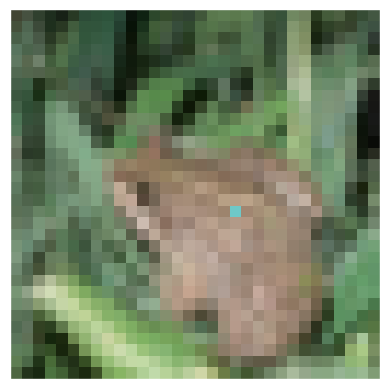

In [12]:
image_id = 4
pixel = np.array([17, 19, 110, 200, 200])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print(type(model.predict_one(x_test[image_id])))

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

Confidence in true class dog is [0.9999331]
Prior confidence was 0.9999733


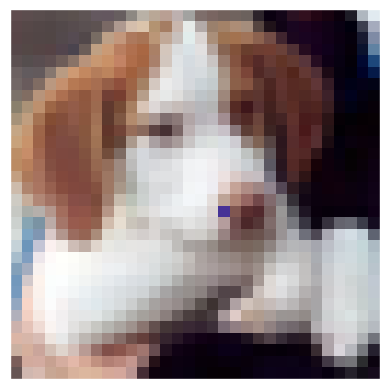

[95 76 78]
[[5, 17, 0.1811955], [6, 14, 0.09939861], [6, 18, 0.09784567], [6, 11, 0.09445697], [6, 17, 0.08650726], [22, 19, 0.06840348], [5, 18, 0.056456804], [3, 12, 0.054075778], [2, 13, 0.053829193], [6, 16, 0.043830395], [7, 12, 0.03764987], [7, 18, 0.035319984], [21, 18, 0.033661485], [6, 13, 0.028870344], [4, 12, 0.02490896], [20, 19, 0.023458362], [5, 14, 0.02083826], [4, 16, 0.01681012], [4, 17, 0.013578534], [5, 13, 0.011624873], [3, 17, 0.010395229], [22, 18, 0.010021746], [4, 14, 0.009427905], [20, 21, 0.009285331], [22, 17, 0.008374929], [1, 10, 0.007924736], [3, 13, 0.0077269673], [7, 11, 0.0075244904], [19, 20, 0.007447958], [20, 20, 0.007189393]]


In [13]:
# this cell is for test
image_id_1 = 16
pixel_1 = np.array([17, 18, 70, 50, 150])
# model = resnet

true_class_1 = y_test[image_id_1, 0]
prior_confidence_1 = model.predict_one(x_test[image_id_1])[true_class_1]
confidence_after_perturb = predict_classes(pixel_1, x_test[image_id_1], true_class_1, model)

print('Confidence in true class', class_names[true_class_1], 'is', confidence_after_perturb)
print('Prior confidence was', prior_confidence_1)
helper.plot_image(perturb_image(pixel_1, x_test[image_id_1]))

print(x_test[image_id_1][0][0])

sensitive_size = 30 # hyperparameter

# pixel_value is triple of (r,g,b) value, img's type is nd.array // 추후 여기 분리하자
def sensitive_pixel_sorting(image_id):
    img = x_test[image_id].copy()
    target_class = y_test[image_id, 0]

    diff_list = [[0,0,0]]

    prior_confidence =  model.predict_one(img)[target_class]

    rgb = [0, 0, 0]

    for x in range(32):
        for y in range(32):

          for i in range(3):
              if img[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img)
          
          after_confidence =  model.predict_one(perturbed_image)[target_class]
          diff_confidence = abs(after_confidence - prior_confidence)

          if diff_confidence > 0:
              for diff_index in range(len(diff_list)):
                  if diff_confidence >= diff_list[diff_index][2]:
                      diff_list.insert(diff_index, [x, y, diff_confidence])
                      if (len(diff_list) > sensitive_size):
                          diff_list.pop()
                      break
    return diff_list

diff_list = sensitive_pixel_sorting(16)
print(diff_list)

In [14]:
# To check confidence score and class of images

con_high_list = [] # 60~99%
con_middle_list = [] # 20~59%
con_low_list = [] # 0~19%


for i in range (4000):
    image_id = i
    true_class = y_test[image_id, 0]
    confidence_score = model.predict_one(x_test[image_id])[true_class]
    # print(confidence_score)
    if confidence_score * 100 >= 60:
        con_high_list.append(i)
    elif 20 <= confidence_score * 100 < 60:
        con_middle_list.append(i)
    else:
        con_low_list.append(i)
    
# print(image_list[16])
# print(confidence_list[16])

print(len(con_high_list))
print(len(con_middle_list))
print(len(con_low_list))




def change_one(change_color, image_id, true_class, stride, pixel_stride):
    x_coord = []

    for i in range(256 // stride):
        x_coord.append(i*4)
    img = x_test[image_id].copy()
    graph_color = 'red'
    original_confidence = model.predict_one(x_test[image_id])[true_class]
    if change_color == 'r':
        target = 2
    elif change_color == 'g':
        target = 3
        graph_color = 'blue'
    elif change_color == 'b':
        target = 4
        graph_color = 'green'
    for i in range(0, 32, pixel_stride):
        for j in range(0, 32, pixel_stride):
            for k in range(256 // stride):
                original_rgb_value = img[i][j]
                pixel = np.array([i, j, img[i][j][0], img[i][j][1], img[i][j][2]])
                pixel[target] = k * stride # 0, 4, ... , 252
                perturbed_confidence = model.predict_one(perturb_image(pixel, img))[true_class]
                # confidence_difference = abs(original_confidence - perturbed_confidence)
                change_confidence_list.append(perturbed_confidence)
    j = 0
    k = -4
    for i in range(64):
        if i%8 == 0:
            k += 4
        plt.plot(x_coord, change_confidence_list[(256 // stride) * i: (256 // stride) * (i+1)], color = graph_color, linestyle = '--', marker = 'o')
        plt.xlabel("rgb value")
        plt.ylabel("confidence score difference")
        plt.title((k,j))
        plt.show()
        j += 4
        if j%32 == 0:
            j = 0

            
# change_one('r', 384, true_class, 4, 4)
            
def change_sensitive(change_color, image_id, true_class, stride):
    x_coord = []

    for i in range(256 // stride):
        x_coord.append(i*4)
    s_list = sensitive_pixel_sorting(image_id)
    img = x_test[image_id].copy()
    graph_color = 'red'
    original_confidence = model.predict_one(x_test[image_id])[true_class]
    if change_color == 'r':
        target = 2
    elif change_color == 'g':
        target = 3
        graph_color = 'blue'
    elif change_color == 'b':
        target = 4
        graph_color = 'green'
    for i in range(30):
        sensitive_x = s_list[i][0]
        sensitive_y = s_list[i][1]
        for k in range(256 // stride):
            original_rgb_value = img[sensitive_x][sensitive_y]
            pixel = np.array([sensitive_x, sensitive_y, img[sensitive_x][sensitive_y][0], img[sensitive_x][sensitive_y][1], img[sensitive_x][sensitive_y][2]])
            pixel[target] = k * stride
            perturbed_confidence = model.predict_one(perturb_image(pixel, img))[true_class]
            # confidence_difference = abs(original_confidence - perturbed_confidence)
            s_change_confidence_list.append(perturbed_confidence)
            
    for i in range(30):
        sensitive_x = s_list[i][0]
        sensitive_y = s_list[i][1]
        plt.plot(x_coord, s_change_confidence_list[(256 // stride) * i: (256 // stride) * (i+1)], color = graph_color, linestyle = '--', marker = 'o')
        plt.xlabel("rgb value")
        plt.ylabel("confidence score difference")
        plt.title((sensitive_x,sensitive_y))
        plt.show() 

#change_sensitive('r', 384, true_class, 4)    





3666
93
241


In [15]:
# This cell is for sensitivity maps

def pixel_confidence(image_id):
    img_original = x_test[image_id].copy()
    img_confidence = x_test[image_id].copy()
    target_class = y_test[image_id, 0]

    helper.plot_image(img_original)

    prior_confidence =  model.predict_one(img_original)[target_class]

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    for x in range(32):
        for y in range(32):
            for i in range(3):
                if img_original[x][y][i] >= 128:
                    rgb[i] = 0
                else:
                    rgb[i] = 255

            pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
            perturbed_image = perturb_image(pixel, img_original)

            after_confidence =  model.predict_one(perturbed_image)[target_class]
            diff_confidence = abs(after_confidence - prior_confidence)

            img_confidence = perturb_image(np.array([x, y,  255 - diff_confidence * 255, 255 - diff_confidence * 255, 255 - diff_confidence * 255]), img_confidence)
    # ----- top 30 or all
    
            if(diff_confidence > 0):
                   for diff_index in range(len(diff_list)):
                    if diff_confidence >= diff_list[diff_index][2]:
                        diff_list.insert(diff_index, [x, y, diff_confidence])
                    if (len(diff_list) > 30):
                        diff_list.pop()
                        break

    for i in range(30):
         img_confidence = perturb_image(np.array([diff_list[i][0], diff_list[i][1],  (30- i) * 8.5, 0, 0]), img_confidence)
    # ------
    print(diff_list)
    helper.plot_image(img_confidence)
    #print(type(img_confidence))

In [16]:
# test for sensitivity maps

#pixel_confidence(20)
#pixel_confidence(25)
#pixel_confidence(87)
#pixel_confidence(125)
#pixel_confidence(368)
#pixel_confidence(384)
#pixel_confidence(520)

In [17]:
# Cell for plot change_one

image_id = 384
true_class = y_test[image_id, 0]
original_confidence = model.predict_one(x_test[image_id])[true_class] # [4] is a cat
s_change_confidence_list = []
change_confidence_list = []
stride = 4
pixel_stride = 4

#change_one('r', image_id, true_class, stride, pixel_stride)
#change_sensitive('r', image_id, true_class, stride)

In [18]:
# Cell for plot change_sensitive

image_id = 384
true_class = y_test[image_id, 0]
original_confidence = model.predict_one(x_test[image_id])[true_class] # [4] is a cat
s_change_confidence_list = []
change_confidence_list = []
stride = 4
pixel_stride = 4

#change_one('r', image_id, true_class, stride, pixel_stride)
#change_sensitive('r', image_id, true_class, stride)

In [19]:

def change_two(change_color1, change_color2, model, image_id, true_class, stride, pixel_stride):
    x_coord = []
    y_coord = []
    change_confidence_list_2 = []
    """
    for i in range(256 // stride):
        x_coord.append(i*stride)
    for i in range(256 // stride):
        y_coord.append(i*stride)
    """
    img = x_test[image_id].copy()
    graph_color = 'red'
    original_confidence = model.predict_one(x_test[image_id])[true_class]
    if change_color1 == change_color2:
        print("same color")
        return;
    if change_color1 == 'r':
        target1 = 2
    elif change_color1 == 'g':
        target1 = 3
        graph_color = 'blue'
    elif change_color1 == 'b':
        target1 = 4
        graph_color = 'green'
    if change_color2 == 'r':
        target2 = 2
    elif change_color2 == 'g':
        target2 = 3
        graph_color = 'blue'
    elif change_color2 == 'b':
        target2 = 4
        graph_color = 'green'
    for i in range(0, 32, pixel_stride):
        for j in range(0, 32, pixel_stride):
            for rgb_x in range(0, 256, stride):
                original_rgb_value = img[i][j]
                pixel = np.array([i, j, img[i][j][0], img[i][j][1], img[i][j][2]])
                pixel[target1] = rgb_x * stride # 0, 4, ... , 252
                for rgb_y in range(0, 256, stride):
                    x_coord.append(rgb_x)
                    y_coord.append(rgb_y)
                    pixel[target2] = rgb_y * stride # 0, 4, ... , 252
                    perturbed_confidence = model.predict_one(perturb_image(pixel, img))[true_class]
                    # confidence_difference = abs(original_confidence - perturbed_confidence)
                    change_confidence_list_2.append(perturbed_confidence)
    
    print(len(x_coord))
    print(len(y_coord))
    print(len(change_confidence_list_2))
    
    for i in range(pixel_stride * pixel_stride):
        graph_1 = plt.figure(1)
        graph_2 = graph_1.add_subplot(111, projection = '3d')
        graph_2.scatter(x_coord[pow((256 // stride), 2) * i: pow((256 // stride), 2) * (i+1)], y_coord[pow((256 // stride), 2) * i: pow((256 // stride), 2) * (i+1)], change_confidence_list_2[pow((256 // stride), 2) * i: pow((256 // stride), 2) * (i+1)], 'r', linestyle = '--', marker = 'o')
        graph_2.set_xlabel(change_color1)
        graph_2.set_ylabel(change_color2)
        graph_2.set_zlabel('perturbed confidence')
        # graph_2.plot_surface(x_coord, y_coord, change_confidence_list_2[(256 // stride) * i: (256 // stride) * (i+1)], cmap = "brg_r")
        #plt.title('perturbed confidence')
        plt.show()
    

In [42]:

def change_two_test(change_color1, change_color2, remained_color, model, image_id, true_class, stride, x, y, remained_rgb, step_color, original):
    x_coord = []
    y_coord = []
    change_confidence_list_2 = []
    x_label = None
    Y_label = None
    z_label = "Confidence score"
    
    img = x_test[image_id].copy()
    graph_color = 'red'
    original_confidence = model.predict_one(x_test[image_id])[true_class]
    
    if change_color1 == change_color2:
        print("same color")
        return;
    if change_color1 == 'r':
        target1 = 2
        x_label = "Red"
    elif change_color1 == 'g':
        target1 = 3
        x_label = "Green"
    elif change_color1 == 'b':
        target1 = 4
        x_label = "Blue"
    if change_color2 == 'r':
        target2 = 2
        y_label = "Red"
    elif change_color2 == 'g':
        target2 = 3
        y_label = "Green"
    elif change_color2 == 'b':
        target2 = 4
        y_label = "Blue"
    if remained_color == 'r':
        target3 = 2
    elif remained_color == 'g':
        target3 = 3
    elif remained_color == 'b':
        target3 = 4
    pixel = np.array([x, y, img[x][y][0], img[x][y][1], img[x][y][2]])
    for rgb_x in range(0, 256, stride):
        pixel[target1] = rgb_x # 0, 4, ... , 252
        for rgb_y in range(0, 256, stride):
            x_coord.append(rgb_x)
            y_coord.append(rgb_y)
            pixel[target2] = rgb_y # 0, 4, ... , 252
            pixel[target3] = remained_rgb
            perturbed_confidence = model.predict_one(perturb_image(pixel, img))[true_class]
            # confidence_difference = abs(original_confidence - perturbed_confidence)
            change_confidence_list_2.append(perturbed_confidence)
    
    
    graph_1 = plt.figure(1)
    graph_2 = graph_1.add_subplot(111, projection = '3d')
    graph_2.scatter(x_coord, y_coord, change_confidence_list_2, 'r', alpha = 0.5)
    graph_2.set_xlabel(x_label)
    graph_2.set_ylabel(y_label)
    graph_2.set_zlabel(z_label)
    
    # you can change file path 
    if original == 'original':
        plt.savefig('../Data_for_Paper/'+ 'graph_' + str(image_id) + '_' + step_color + '_' +  original + '.png', bbox_inches = 'tight', pad_inches = 0.25)
    else:
        plt.savefig('../Data_for_Paper/' + 'graph_' + str(image_id) + '_' + step_color + '_' +  str(remained_rgb) + '.png',bbox_inches = 'tight', pad_inches = 0.25)
    plt.show()
    

In [43]:
#list1 = sensitive_pixel_sorting(384) # high confidence, bird
#print(list1)
#list2 = sensitive_pixel_sorting(1470) # low confidence, horse
#list3 = sensitive_pixel_sorting(4) # high confidence, frog
#print(list3)
#list4 = sensitive_pixel_sorting(771) # middle confidence, automobile
#print(list4)
#list4 = sensitive_pixel_sorting(1492) # middle confidence, truck
#print(list4)
image_id = 384
list4 = sensitive_pixel_sorting(image_id) # middle confidence, horse
print(list4)
print("\n\n\n")
#print(list2)

[[16, 13, 0.7065553], [17, 15, 0.70654714], [16, 12, 0.7064547], [15, 14, 0.7063695], [16, 14, 0.7063457], [18, 13, 0.70632], [15, 12, 0.7062548], [14, 15, 0.7062262], [13, 15, 0.7061345], [14, 14, 0.7061022], [14, 13, 0.70606136], [17, 13, 0.7059981], [18, 12, 0.7058054], [17, 12, 0.7057074], [15, 13, 0.70558375], [14, 12, 0.7054256], [12, 14, 0.7054158], [17, 14, 0.70184577], [13, 14, 0.7009566], [12, 13, 0.70007956], [27, 14, 0.6989042], [11, 13, 0.696449], [16, 15, 0.6958393], [28, 12, 0.6941298], [15, 16, 0.6938345], [22, 20, 0.6917767], [28, 13, 0.6908335], [29, 12, 0.68843883], [28, 14, 0.68795294], [21, 20, 0.6875751]]






[181 168 130]
17
14


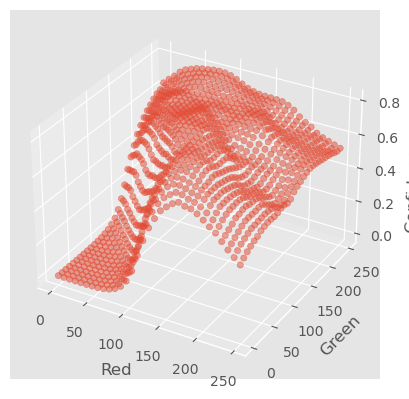


from here, blue will changed with stride 10




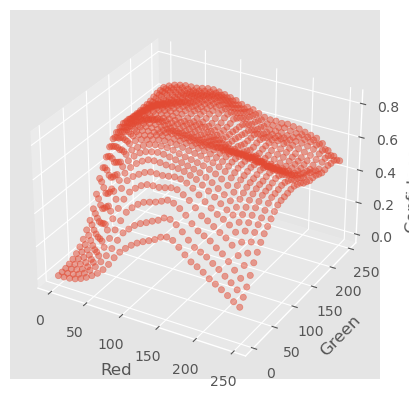

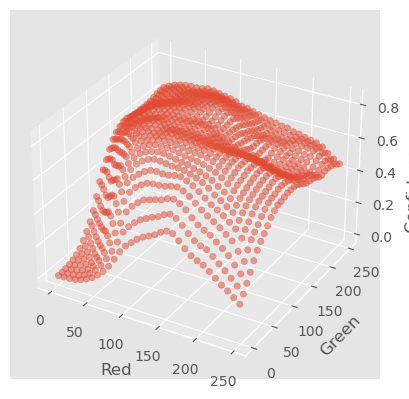

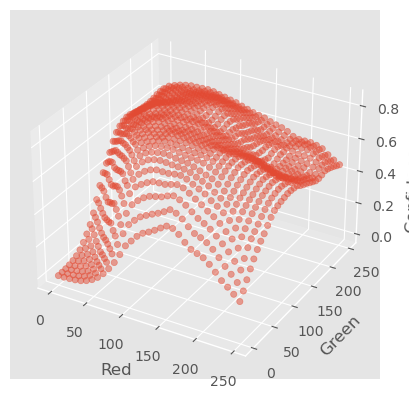

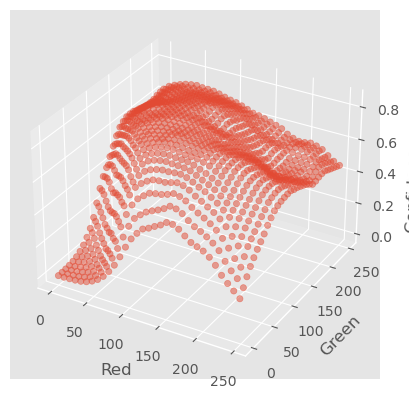

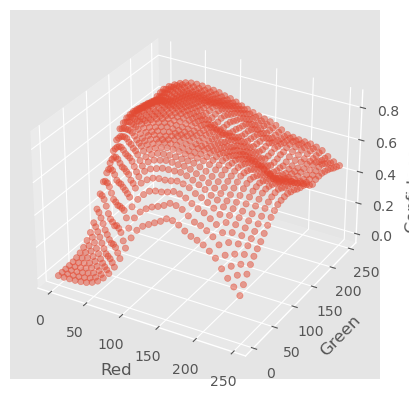

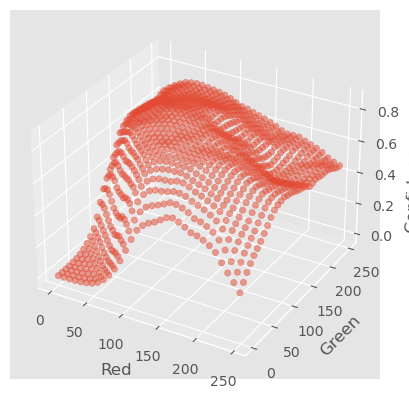

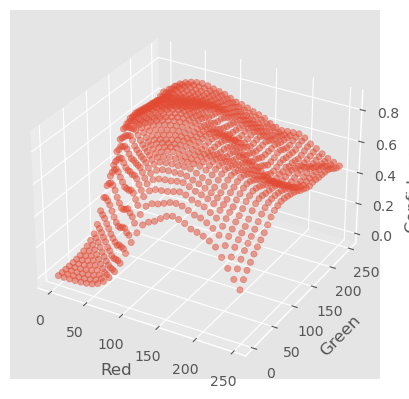

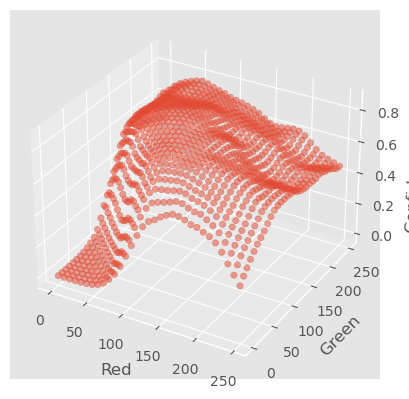

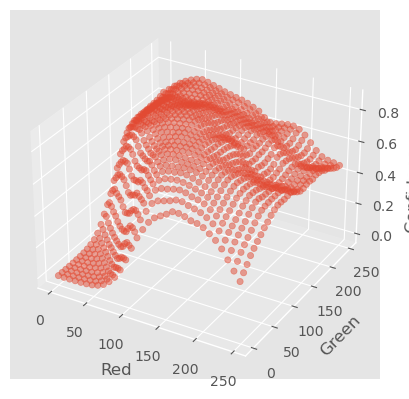

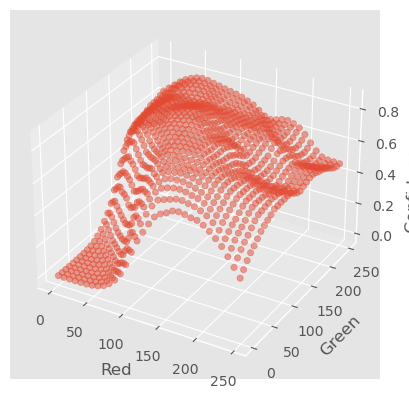

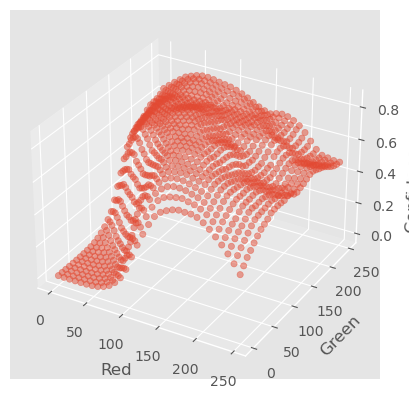

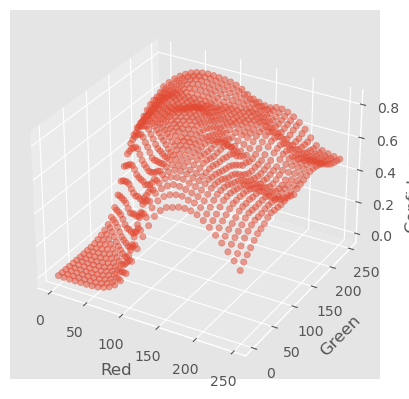

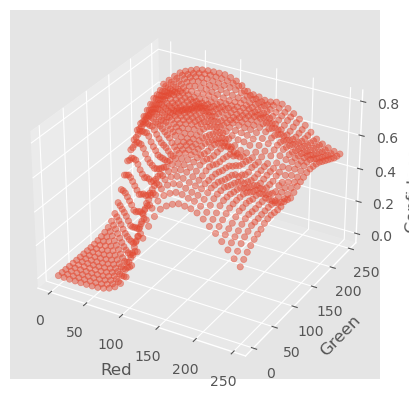

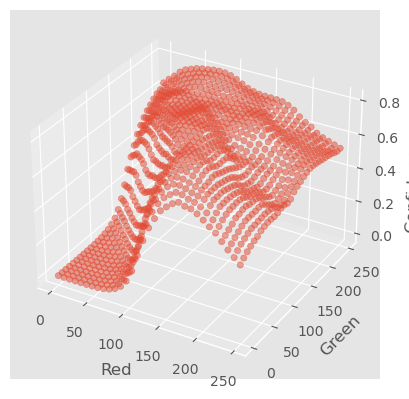

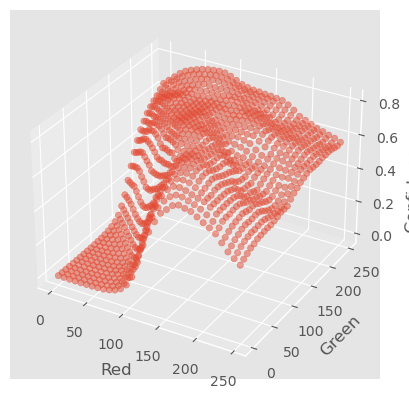

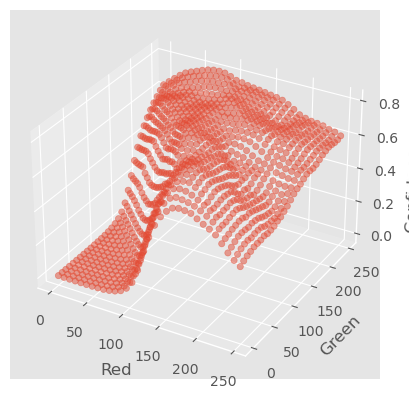

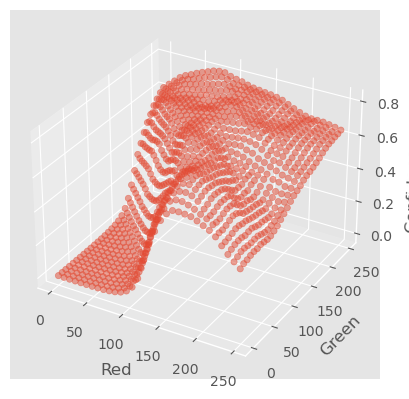

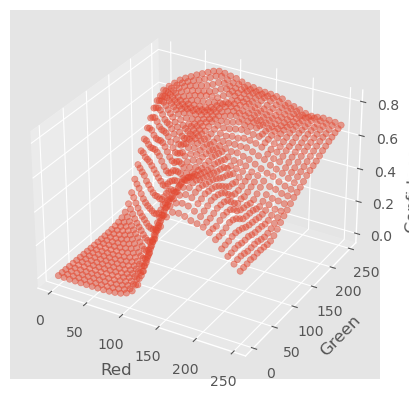

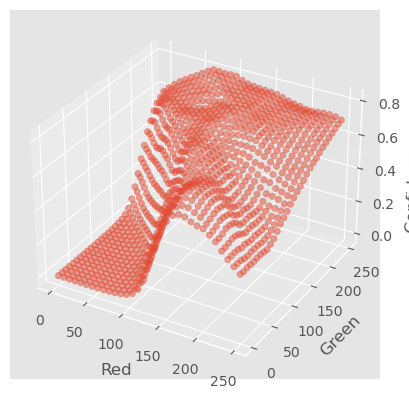

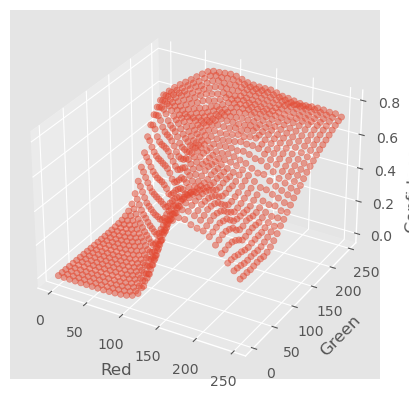

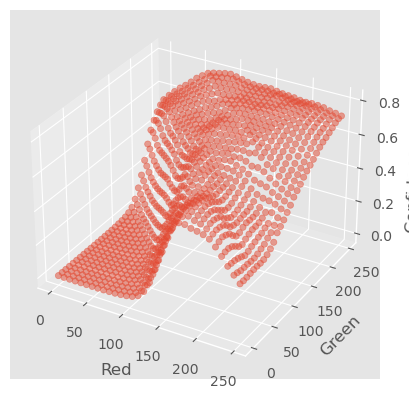

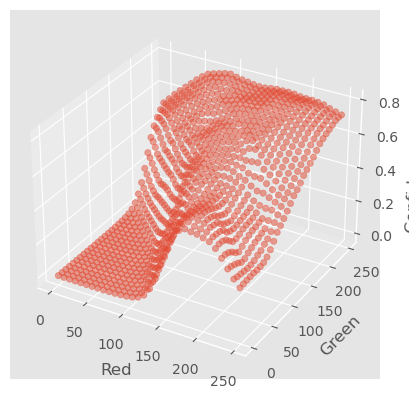

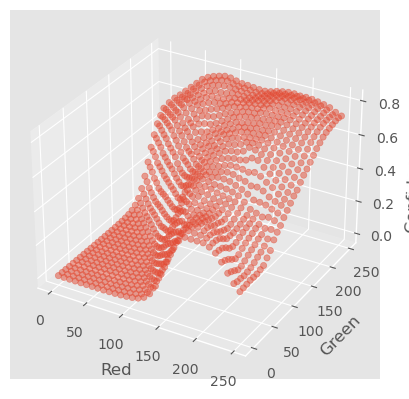

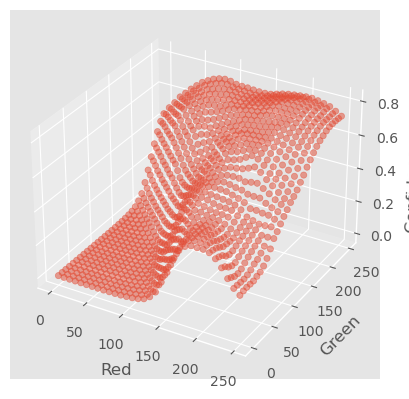

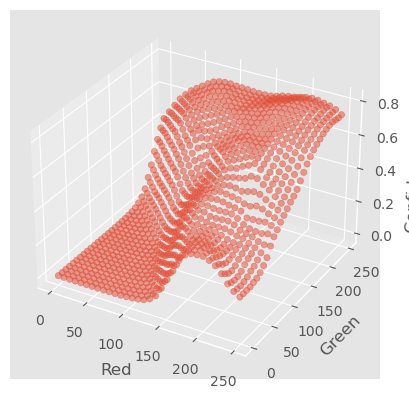

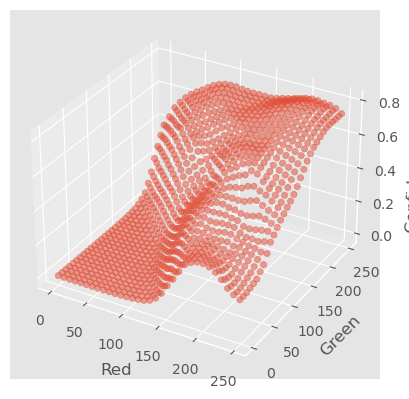

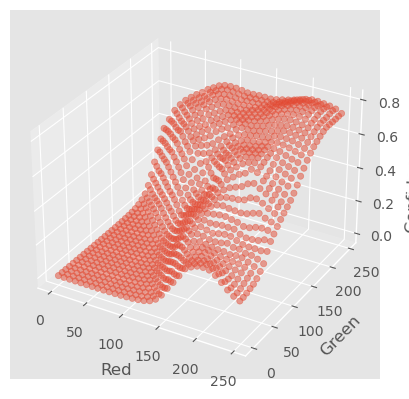

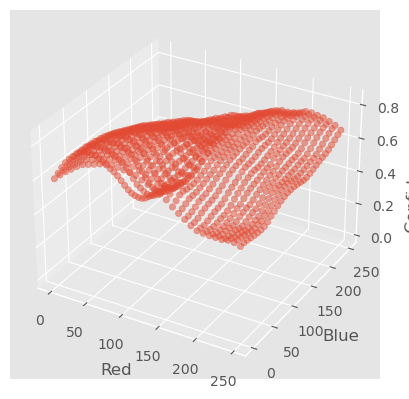


from here, green will changed with stride 10




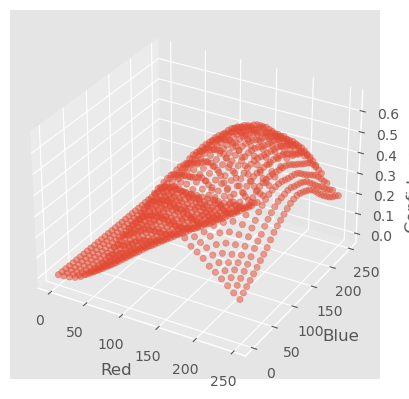

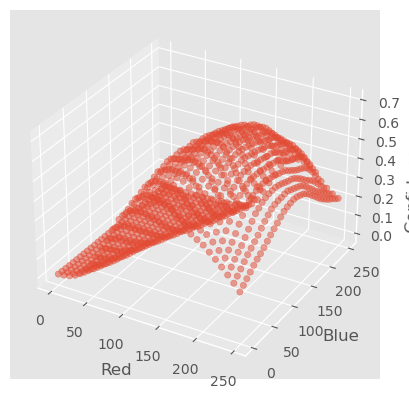

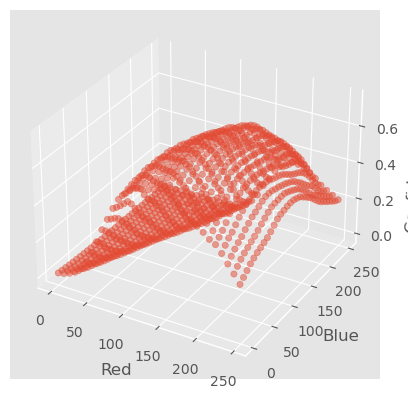

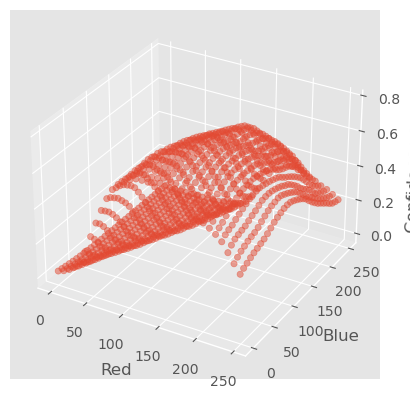

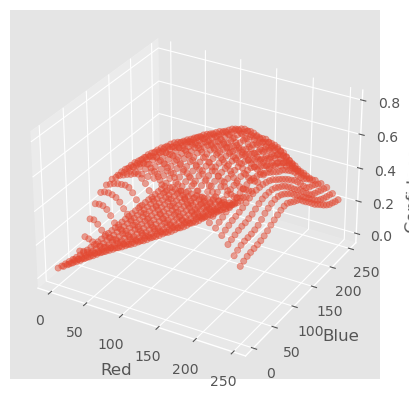

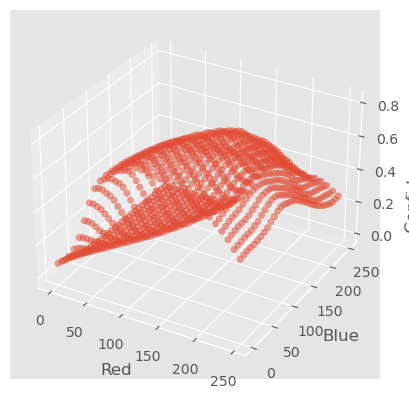

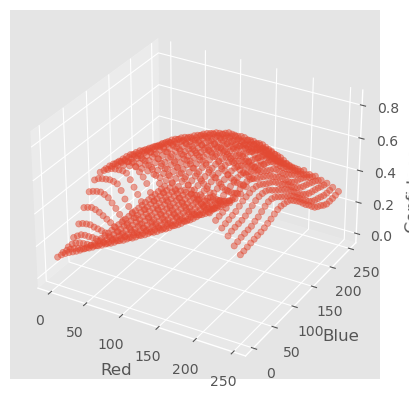

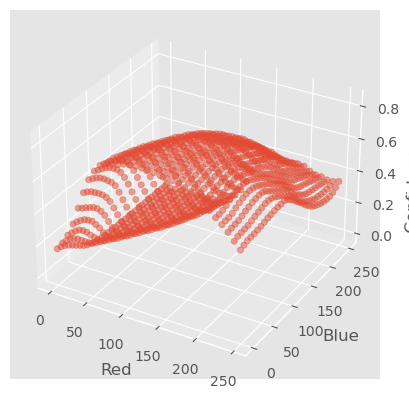

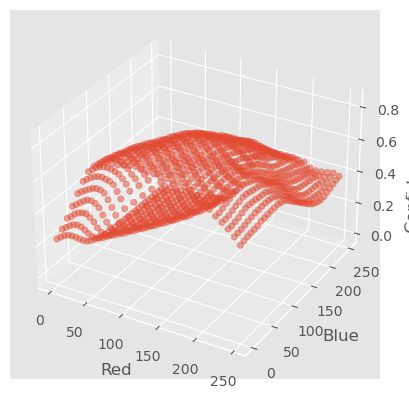

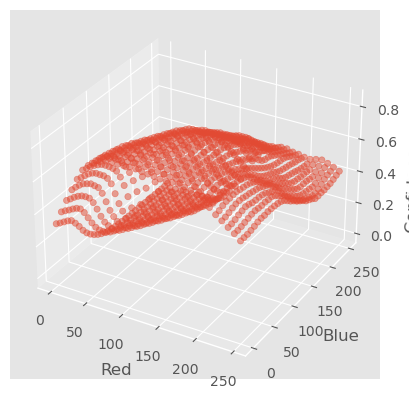

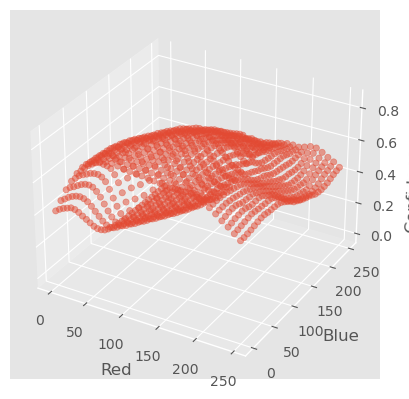

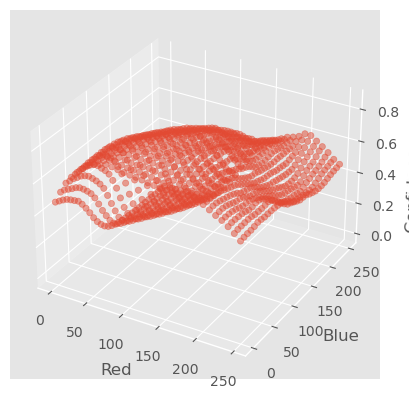

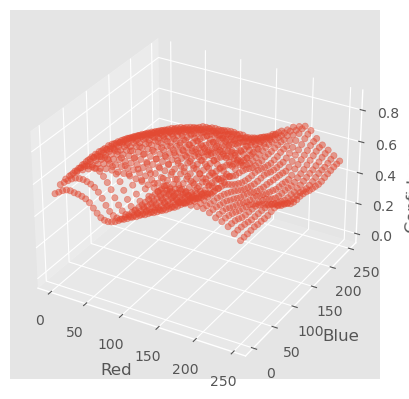

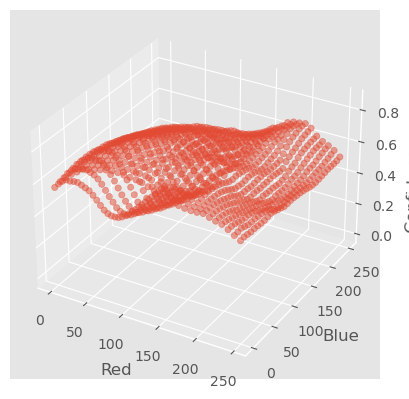

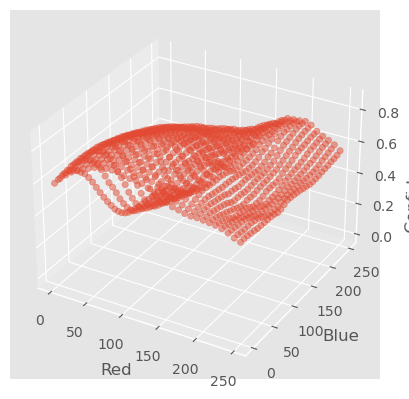

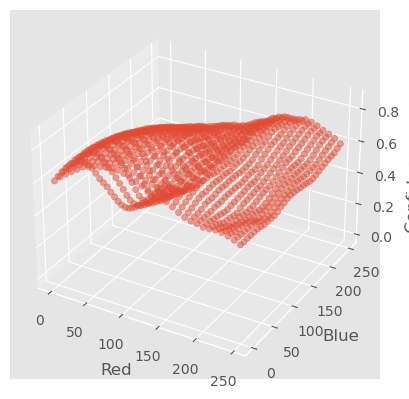

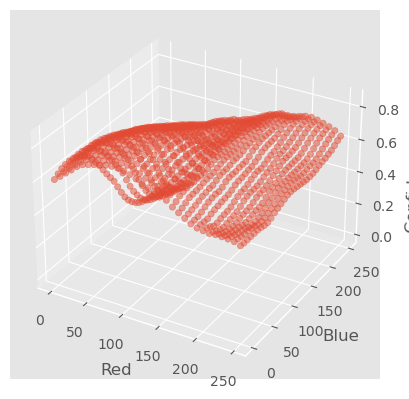

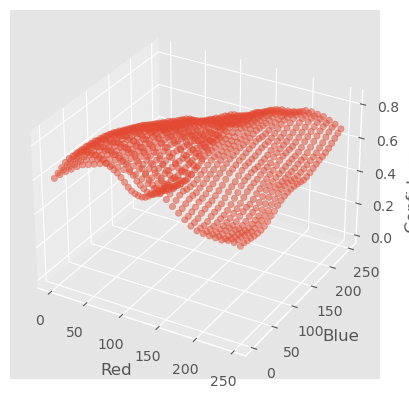

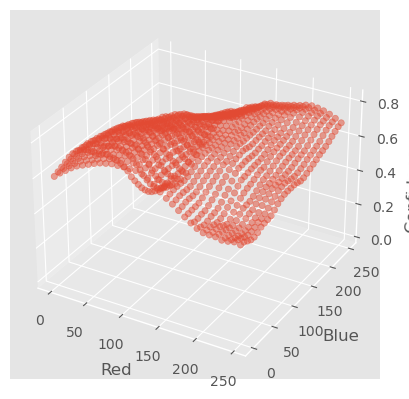

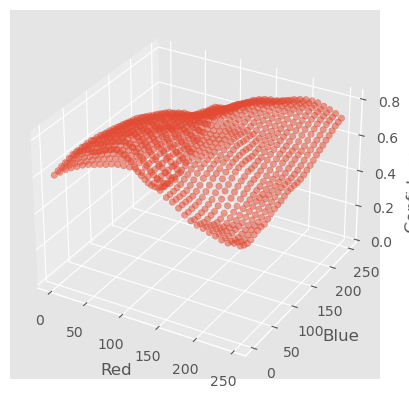

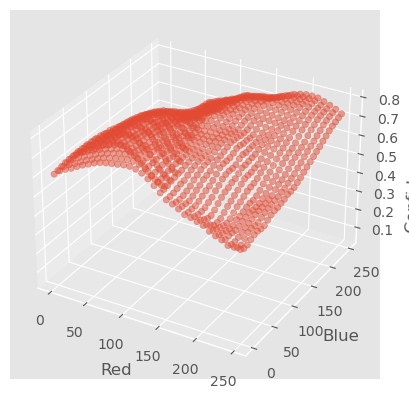

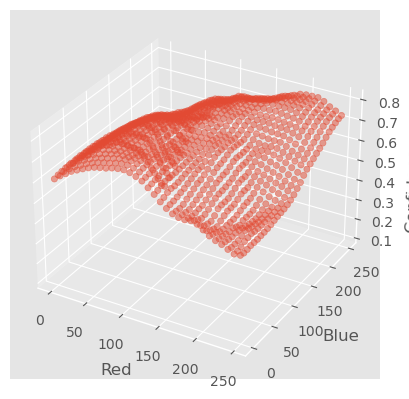

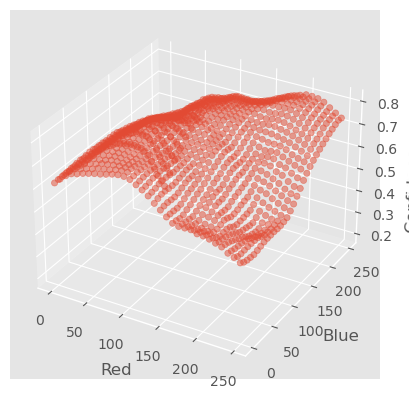

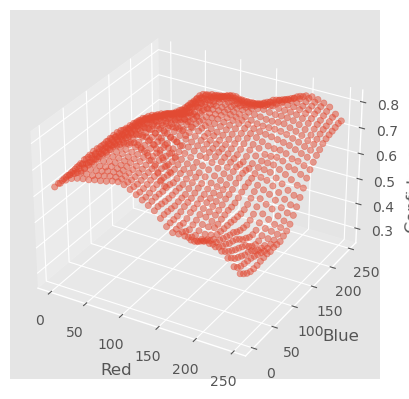

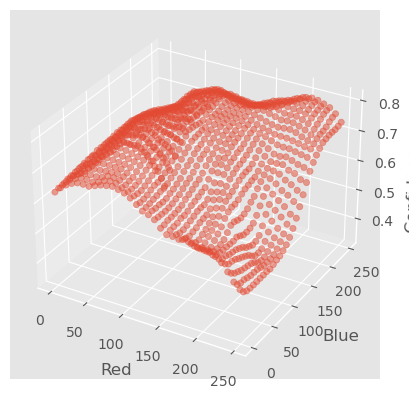

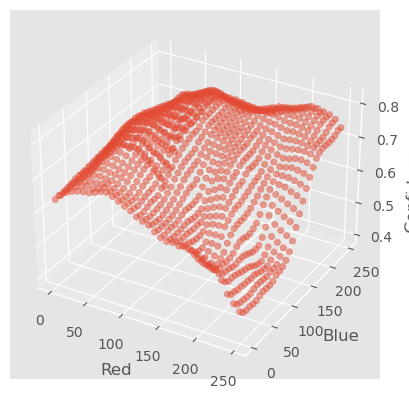

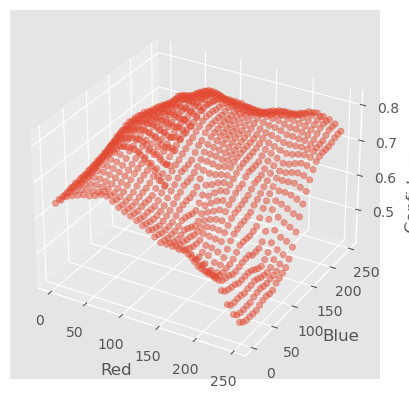

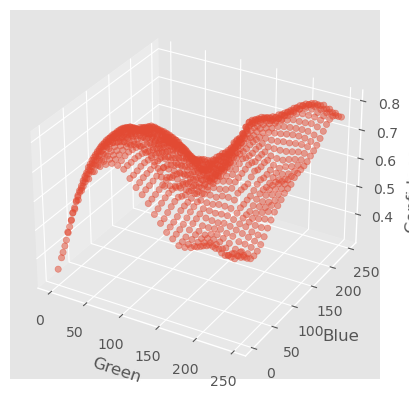


from here, red will changed with stride 10




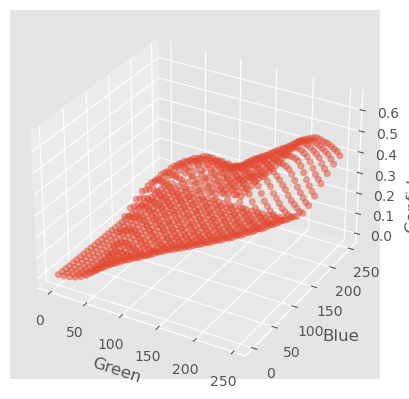

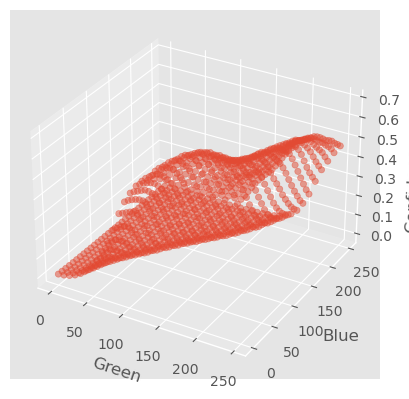

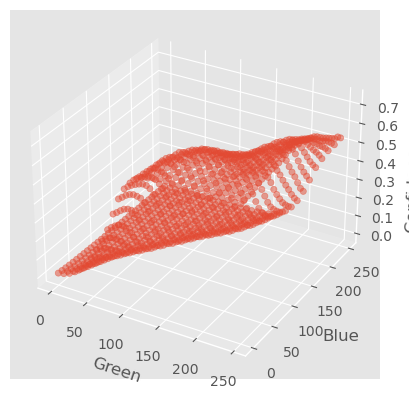

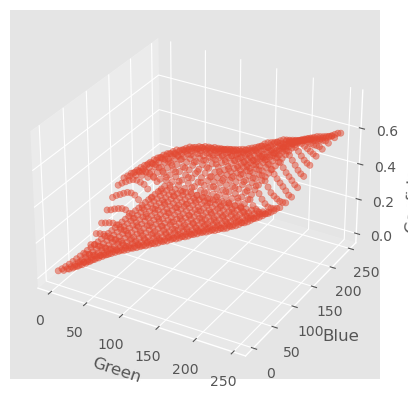

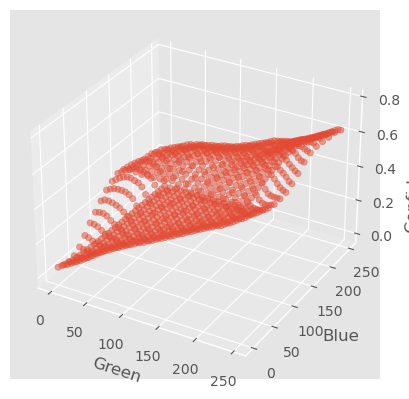

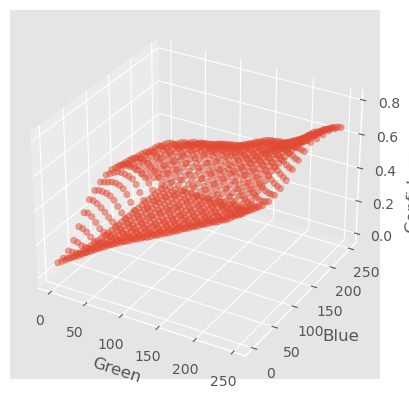

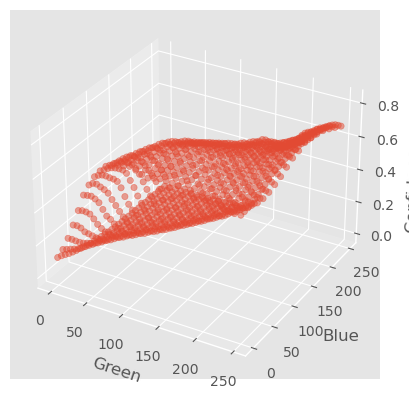

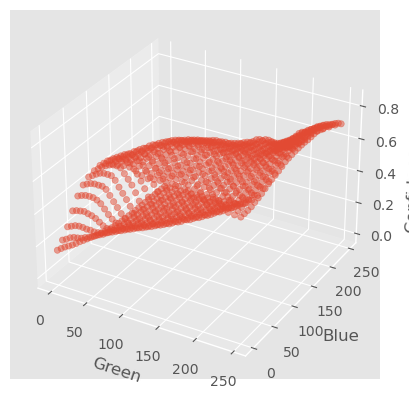

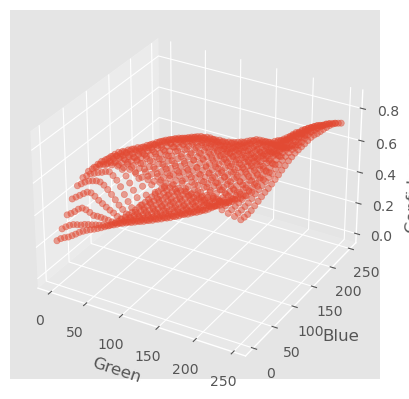

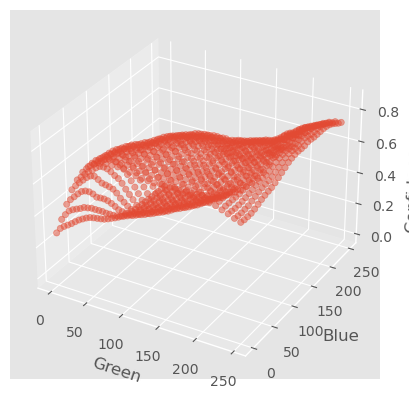

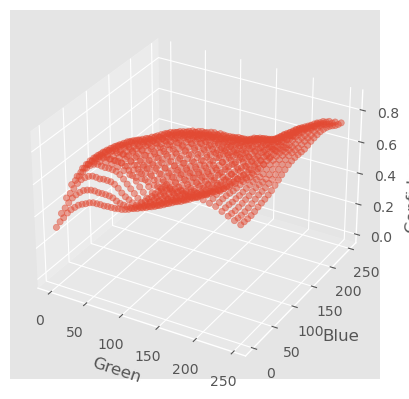

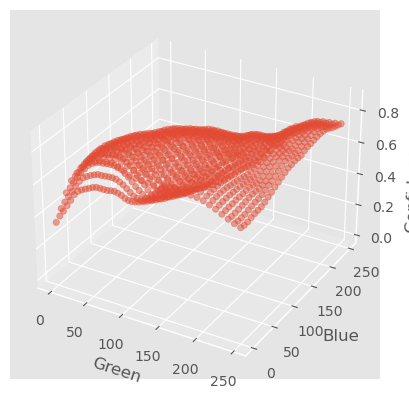

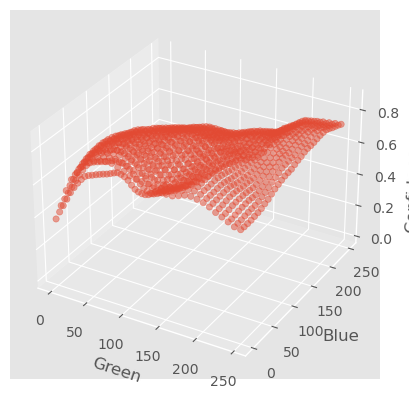

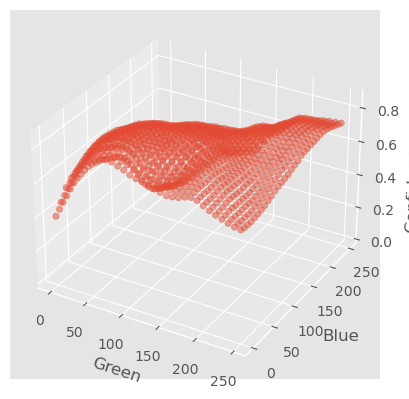

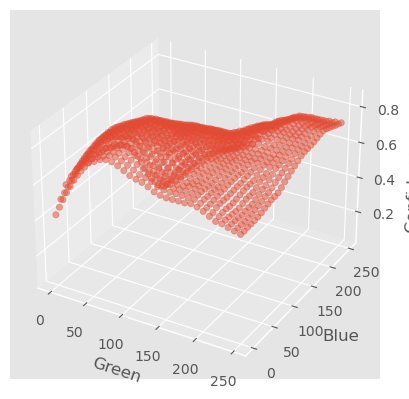

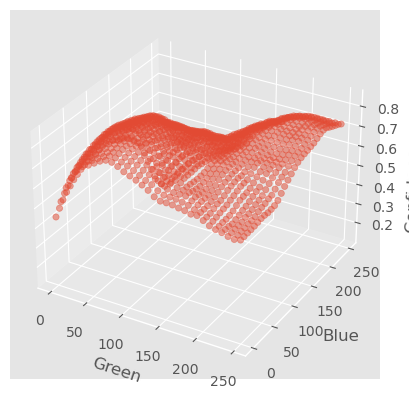

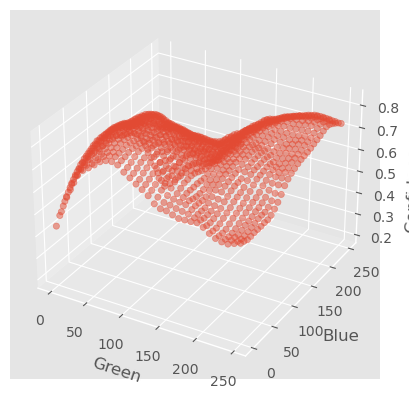

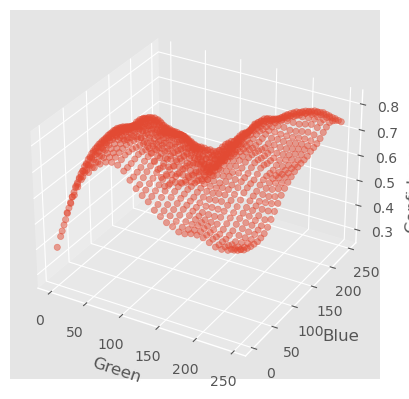

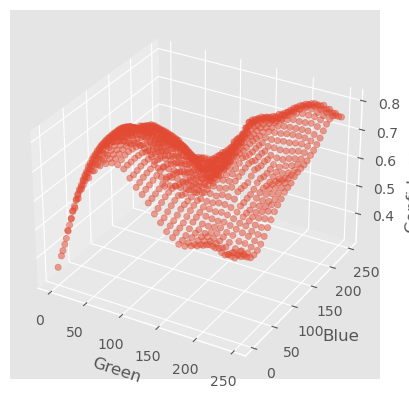

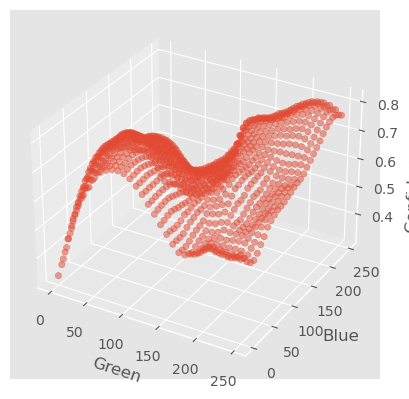

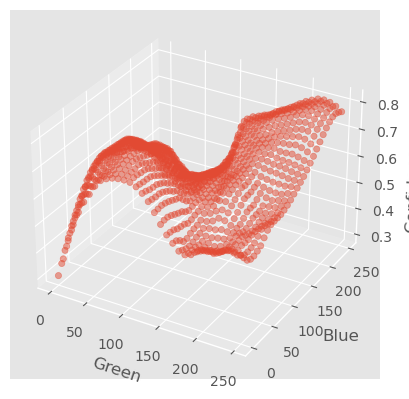

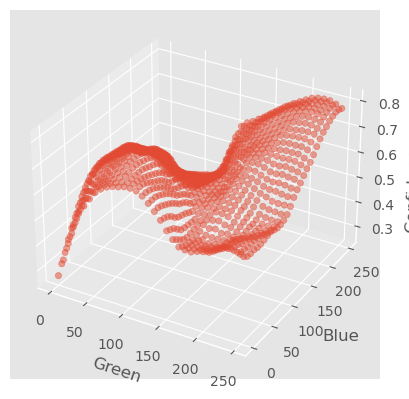

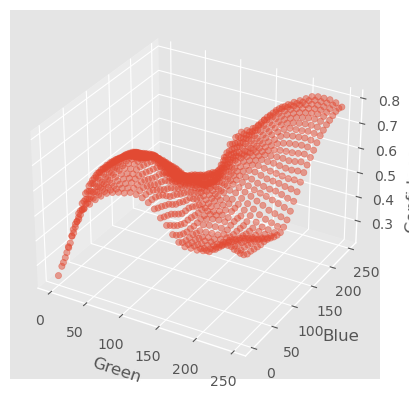

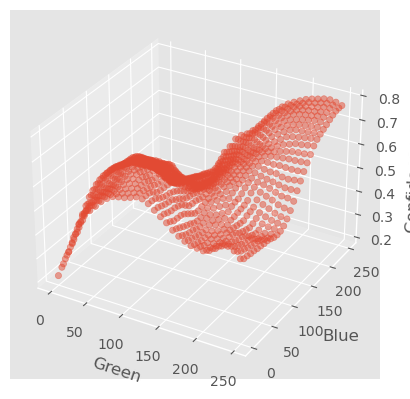

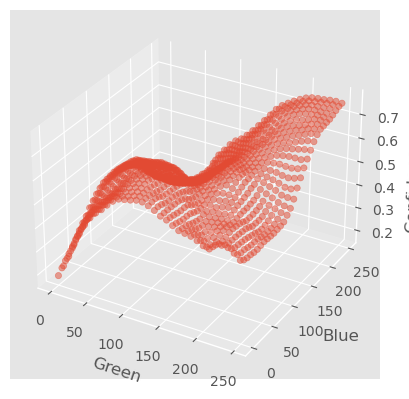

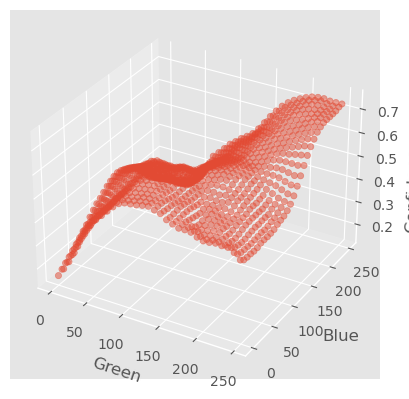

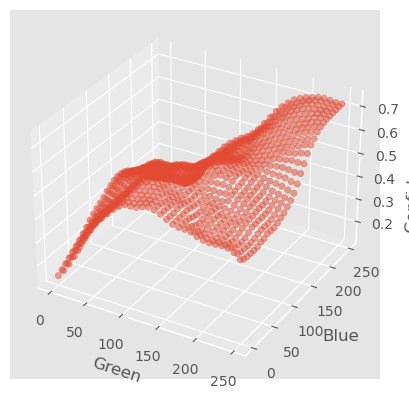

'\n#from here, random piexl and r,g are main\nchange_two_test(\'r\', \'g\', \'b\', graph_model, image_id, true_class, stride, 16, 17, random_rgb[2]) # sensitive\nprint("\nfrom here, blue will changed with stride 10, random pixel\n\n")\nfor remained_rgb in range(0, 255, 10):\n    change_two_test(\'r\', \'g\', \'b\', graph_model, image_id, true_class, stride, 16, 17, remained_rgb) # r,g\n#change_two_test(\'r\', \'b\', graph_model, image_id, true_class, stride, 16, 17) # random\n#change_two_test(\'r\', \'b\', graph_model, image_id, true_class, stride, 24, 12) # weired\n'

In [44]:
# high confidence image
true_class = y_test[image_id, 0]
stride = 8
test_image = x_test[image_id].copy()
sensitive_rgb = test_image[sensitive_x][sensitive_y] # most sensitive coordinate
print(sensitive_rgb)


sensitive_ranking = 17 # 몇 등인지 나타내는 변수, 0~29
sensitive_x = list4[sensitive_ranking][0]
sensitive_y = list4[sensitive_ranking][1]
print(sensitive_x)
print(sensitive_y)

random_rgb = test_image[16][17] # random coordinate
# pixel_stride = 8
graph_model = resnet
# print(sensitive_pixel_sorting(384))
# change_two('r', 'g', graph_model, image_id, true_class, stride, pixel_stride)



# ------------

# r,g are main
change_two_test('r', 'g', 'b', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, sensitive_rgb[2], 'blue', 'original') # sensitive
print("\nfrom here, blue will changed with stride 10\n\n")
for remained_rgb in range(0, 255, 10):
    change_two_test('r', 'g', 'b', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, remained_rgb, 'blue', 'n') # r,g
    if(remained_rgb == 250):
        change_two_test('r', 'g', 'b', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, 255, 'blue', 'n')


# -------------    
    
# r,b are main
change_two_test('r', 'b', 'g', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, sensitive_rgb[1], 'green', 'original') # sensitive
print("\nfrom here, green will changed with stride 10\n\n")
for remained_rgb in range(0, 255, 10):
    change_two_test('r', 'b', 'g', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, remained_rgb, 'green', 'n') # r,b
    if(remained_rgb == 250):
        change_two_test('r', 'b', 'g', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, 255, 'green', 'n')
# --------------    


# g,b are main
change_two_test('g', 'b', 'r', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, sensitive_rgb[0], 'red', 'original') # sensitive
print("\nfrom here, red will changed with stride 10\n\n")
for remained_rgb in range(0, 255, 10):
    change_two_test('g', 'b', 'r', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, remained_rgb, 'red', 'n') # r,g
    if(remained_rgb == 250):
        change_two_test('g', 'b', 'r', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, 255, 'red', 'n')

# --------------




"""
#from here, random piexl and r,g are main
change_two_test('r', 'g', 'b', graph_model, image_id, true_class, stride, 16, 17, random_rgb[2]) # sensitive
print("\nfrom here, blue will changed with stride 10, random pixel\n\n")
for remained_rgb in range(0, 255, 10):
    change_two_test('r', 'g', 'b', graph_model, image_id, true_class, stride, 16, 17, remained_rgb) # r,g
#change_two_test('r', 'b', graph_model, image_id, true_class, stride, 16, 17) # random
#change_two_test('r', 'b', graph_model, image_id, true_class, stride, 24, 12) # weired
"""




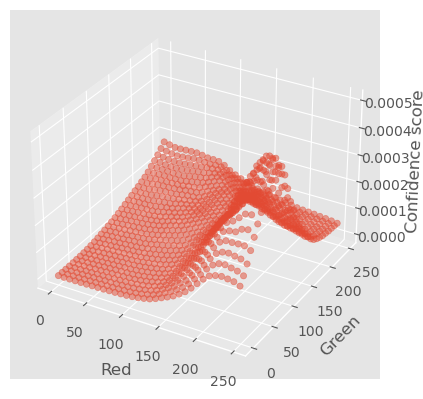

In [41]:
# Test cell for graph padding

change_two_test('r', 'g', 'b', graph_model, image_id, true_class, stride, sensitive_x, sensitive_y, 255, 'blue', 'n')

In [35]:
print(os.path.abspath("Data_for_Paper"))

/Users/kunhakim/Documents/Papers_and_Reference/one-pixel-attack-keras-master/Data_for_Paper


## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

[Part 2](1_one-pixel-attack-cifar10.ipynb)

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar